Simulated BGS galaxy spectra are generated using dark and bright sky spectrum then 
run through the `redrock` pipeline in order to measure redshifts. 



In [1]:
import os
import numpy as np 
# -- astropy --
from astropy.io import fits
from desispec.io import read_spectra
from desispec.io import write_spectra
from desispec.spectra import Spectra
# -- local --
from feasibgs import util as UT
from feasibgs import catalogs as Cat
from feasibgs import forwardmodel as FM

In [2]:
import matplotlib as mpl 
import matplotlib.pyplot as pl 
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False
%matplotlib inline

Read in Gama-Legacy catalog

In [3]:
field = 'g15'
cata = Cat.GamaLegacy()
gleg = cata.Read(field)

properties of the GAMA-Legacy survey 

In [4]:
redshift = gleg['gama-spec']['z']
ngal = len(redshift)
print('%i galaxies in the GAMA-Legacy survey' % ngal)

63004 galaxies in the GAMA-Legacy survey


In [5]:
# apparent magnitudes from Legacy photometry
g_mag_legacy = UT.flux2mag(gleg['legacy-photo']['flux_g'])#, method='log')
r_mag_legacy = UT.flux2mag(gleg['legacy-photo']['flux_r'])#, method='log')
# apparent magnitude from Legacy photometry aperture flux
g_mag_legacy_apflux = UT.flux2mag(gleg['legacy-photo']['apflux_g'][:,1])
r_mag_legacy_apflux = UT.flux2mag(gleg['legacy-photo']['apflux_r'][:,1])
# apparent magnitude from GAMA photometry
g_mag_gama = UT.flux2mag(gleg['gama-photo']['modelmag_g'])
r_mag_gama = UT.flux2mag(gleg['gama-photo']['modelmag_r'])
# H-alpha line flux from GAMA spectroscopy
gama_ha = gleg['gama-spec']['ha_flux']

# absolute magnitude calculated using GAMA photometry
absmag_ugriz = cata.AbsMag(gleg, kcorr=0.1, H0=70, Om0=0.3)
g_absmag_gama = absmag_ugriz[1,:]
r_absmag_gama = absmag_ugriz[2,:]

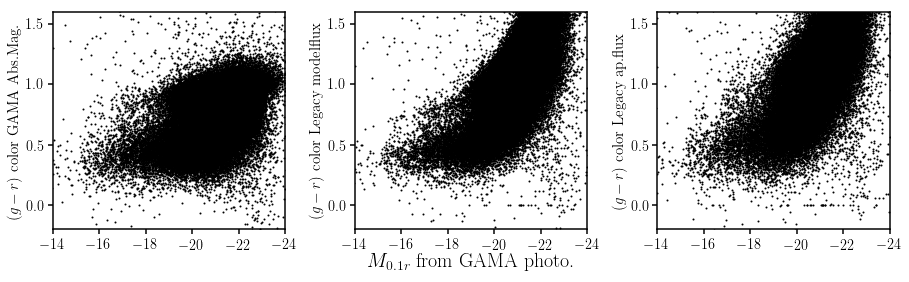

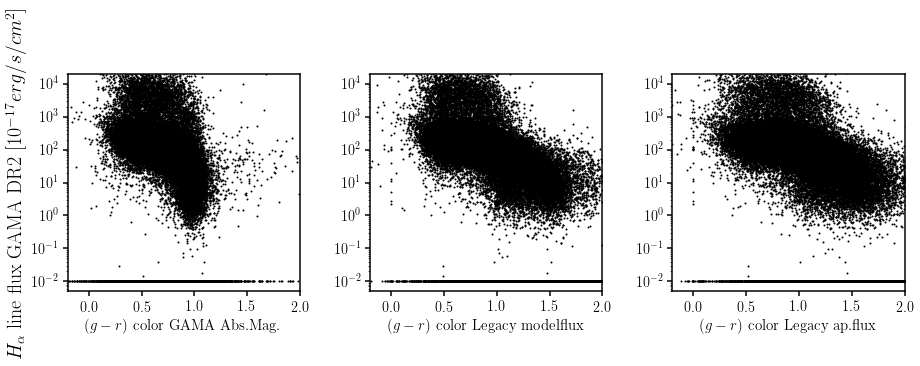

In [6]:
fig = plt.figure(figsize=(15, 4))
ys = [g_absmag_gama-r_absmag_gama, g_mag_legacy - r_mag_legacy, g_mag_legacy_apflux - r_mag_legacy_apflux]
ylbls = ['GAMA Abs.Mag.', 'Legacy modelflux', 'Legacy ap.flux']
for i, y, ylbl in zip(range(1,4), ys, ylbls):
    sub = fig.add_subplot(1,3,i)
    sub.scatter(r_absmag_gama, y, c='k', s=1.)
    if i == 2: sub.set_xlabel('$M_{0.1r}$ from GAMA photo.', fontsize=20)
    sub.set_xlim([-14., -24])
    sub.set_ylabel(r'$(g-r)$ color '+ylbl, fontsize=15)
    sub.set_ylim([-0.2, 1.6])
fig.subplots_adjust(wspace=0.3)

fig = plt.figure(figsize=(15, 4))
xs = [g_absmag_gama-r_absmag_gama, g_mag_legacy - r_mag_legacy, g_mag_legacy_apflux - r_mag_legacy_apflux]
xlbls = ['GAMA Abs.Mag.', 'Legacy modelflux', 'Legacy ap.flux']
for i, x, xlbl in zip(range(1,len(xs)+1), ys, ylbls):
    sub = fig.add_subplot(1, len(xs), i)
    hasha = (gama_ha > 0)
    sub.scatter(x[hasha], gama_ha[hasha], s=1, c='k')
    sub.scatter(x[np.invert(hasha)], np.repeat(1e-2, np.sum(np.invert(hasha))), s=1, c='k')
    sub.set_xlabel(r'$(g-r)$ color '+xlbl, fontsize=15)
    sub.set_xlim([-0.2, 2.])
    if i == 1: sub.set_ylabel(r'$H_\alpha$ line flux GAMA DR2 $[10^{-17}erg/s/cm^2]$', fontsize=20)
    sub.set_ylim([5e-3, 2e4])
    sub.set_yscale('log')
fig.subplots_adjust(wspace=0.3)

Read in the `redrock` redshift measurements for a subsample of the simulated spectra 

In [7]:
f_z_dark = ''.join([UT.dat_dir(), 'redrock/', 'GamaLegacy.', field, '.expSpectra.darksky.seed1.exptime300.faintEmLine.redrock.fits'])
zdark_data = fits.open(f_z_dark)[1].data

f_i_dark = ''.join([UT.dat_dir(), 'spectra/', 'GamaLegacy.', field, '.expSpectra.darksky.seed1.exptime300.faintEmLine.index'])
i_dark = np.loadtxt(f_i_dark, unpack=True, usecols=[0], dtype='i')

f_z_bright = ''.join([UT.dat_dir(), 'redrock/', 'GamaLegacy.', field, '.expSpectra.brightsky.seed1.exptime300.faintEmLine.redrock.fits'])
zbright_data = fits.open(f_z_bright)[1].data

f_i_bright = ''.join([UT.dat_dir(), 'spectra/', 'GamaLegacy.', field, '.expSpectra.darksky.seed1.exptime300.faintEmLine.index']) 
i_bright = np.loadtxt(f_i_bright, unpack=True, usecols=[0], dtype='i')
assert np.array_equal(i_dark, i_bright)
assert len(i_dark) == len(np.unique(i_dark))
print('%i redshifts' % len(zdark_data['Z']))

1000 redshifts


In [8]:
print('%i spectra w/ dark sky ZWARN != 0' % np.sum(zdark_data['ZWARN'] != 0)) 
print('%i spectra w/ bright sky ZWARN != 0' % np.sum(zbright_data['ZWARN'] != 0)) 

7 spectra w/ dark sky ZWARN != 0
13 spectra w/ bright sky ZWARN != 0


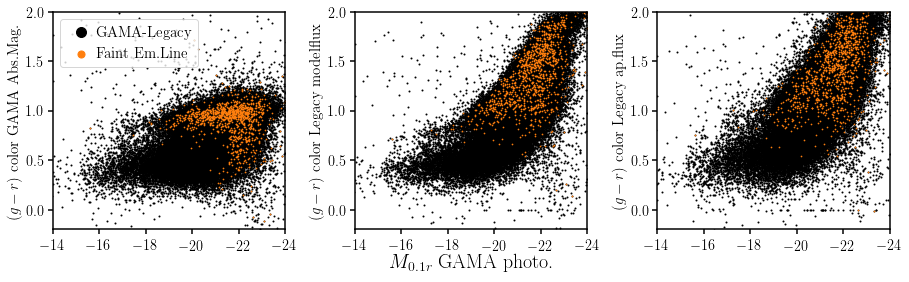

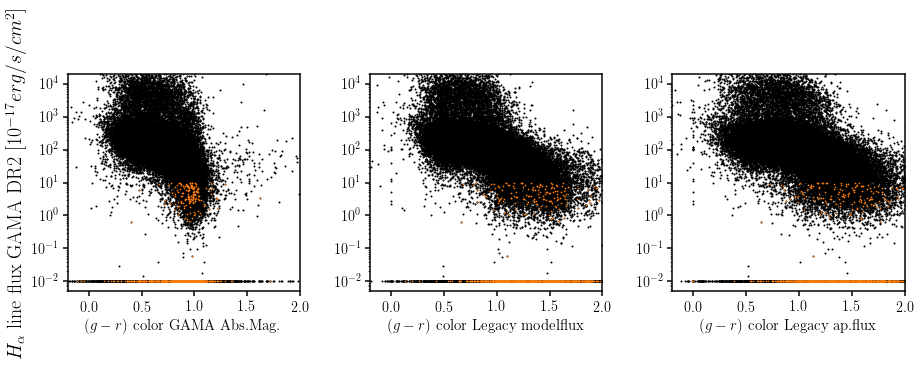

In [9]:
fig = plt.figure(figsize=(15, 4))
ys = [g_absmag_gama-r_absmag_gama, g_mag_legacy - r_mag_legacy, g_mag_legacy_apflux - r_mag_legacy_apflux]
ylbls = ['GAMA Abs.Mag.', 'Legacy modelflux', 'Legacy ap.flux']
for i, y, ylbl in zip(range(1,4), ys, ylbls):
    sub = fig.add_subplot(1,3,i)
    sub.scatter(r_absmag_gama, y, c='k', s=1., label='GAMA-Legacy')
    sub.scatter(r_absmag_gama[i_dark], y[i_dark], c='C1', s=0.5, label='Faint Em.Line')
    if i == 2: sub.set_xlabel('$M_{0.1r}$ GAMA photo.', fontsize=20)
    sub.set_xlim([-14., -24])
    sub.set_ylabel(r'$(g-r)$ color '+ylbl, fontsize=15)
    sub.set_ylim([-0.2, 2.])
    if i == 1: sub.legend(loc="upper left", markerscale=10, handletextpad=0., frameon=True, prop={'size':15})
fig.subplots_adjust(wspace=0.3)

fig = plt.figure(figsize=(15, 4))
xs = [g_absmag_gama-r_absmag_gama, g_mag_legacy - r_mag_legacy, g_mag_legacy_apflux - r_mag_legacy_apflux]
xlbls = ['GAMA Abs.Mag.', 'Legacy modelflux', 'Legacy ap.flux']
for i, x, xlbl in zip(range(1,len(xs)+1), ys, ylbls):
    sub = fig.add_subplot(1, len(xs), i)
    hasha = (gama_ha > 0)
    faintem = np.zeros(ngal, dtype=bool)
    faintem[i_dark] = True
    sub.scatter(x[hasha], gama_ha[hasha], s=1, c='k')
    sub.scatter(x[np.invert(hasha)], np.repeat(1e-2, np.sum(np.invert(hasha))), s=1, c='k')
    sub.scatter(x[faintem & hasha], gama_ha[faintem & hasha], c='C1', s=0.5)
    sub.scatter(x[faintem & np.invert(hasha)], np.repeat(1e-2, np.sum(faintem & np.invert(hasha))), c='C1', s=0.5)
    sub.set_xlabel(r'$(g-r)$ color '+xlbl, fontsize=15)
    sub.set_xlim([-0.2, 2.])
    if i == 1: sub.set_ylabel(r'$H_\alpha$ line flux GAMA DR2 $[10^{-17}erg/s/cm^2]$', fontsize=20)
    sub.set_ylim([5e-3, 2e4])
    sub.set_yscale('log')
fig.subplots_adjust(wspace=0.3)

(4.0, -2.5)

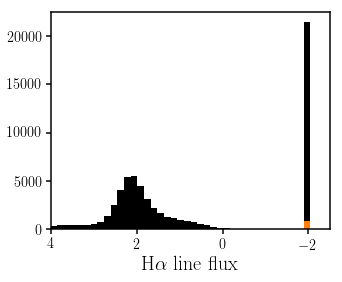

In [10]:
fig = plt.figure(figsize=(5,4))
sub = fig.add_subplot(111)
hasha = (gama_ha > 0.)
_ = sub.hist(np.log10(np.concatenate([gama_ha[hasha], np.repeat(1e-2, np.sum(np.invert(hasha)))])), histtype='stepfilled', range=(-2.2, 4), bins=40, color='k')
_ = sub.hist(np.log10(np.concatenate([gama_ha[faintem & hasha], np.repeat(1e-2, np.sum(faintem & np.invert(hasha)))])), histtype='stepfilled', range=(-2.2, 4), bins=40, color='C1')
sub.set_xlabel(r'H$\alpha$ line flux', fontsize=20)
sub.set_xlim([4., -2.5])

(18, 22.0)

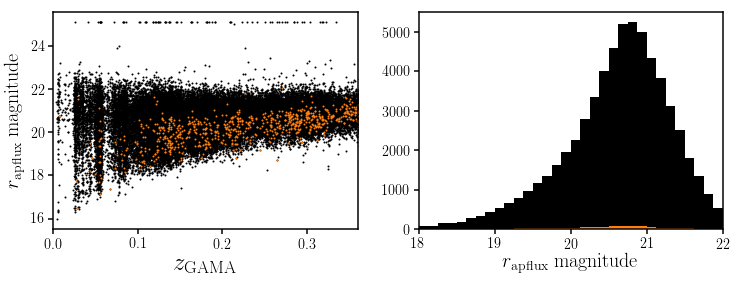

In [11]:
fig = plt.figure(figsize=(12,4))
sub1 = fig.add_subplot(121)
sub1.scatter(redshift, r_mag_legacy_apflux, s=1, c='k')
sub1.scatter(redshift[faintem], r_mag_legacy_apflux[faintem], s=1, c='C1')
sub1.set_xlabel(r'$z_\mathrm{GAMA}$', fontsize=25)
sub1.set_xlim([0., 0.36])
sub1.set_ylabel(r'$r_\mathrm{apflux}$ magnitude', fontsize=20)
sub2 = fig.add_subplot(122)
_ = sub2.hist(r_mag_legacy_apflux, histtype='stepfilled', range=(17, 22), bins=40, color='k')
_ = sub2.hist(r_mag_legacy_apflux[faintem], histtype='stepfilled', range=(17, 22), bins=40, color='C1')
sub2.set_xlabel(r'$r_\mathrm{apflux}$ magnitude', fontsize=20)
sub2.set_xlim([18, 22.])

Lets compare the redshift we measure from redrock to the "true" input redshift from GAMA. 

(0.1, 1.0)

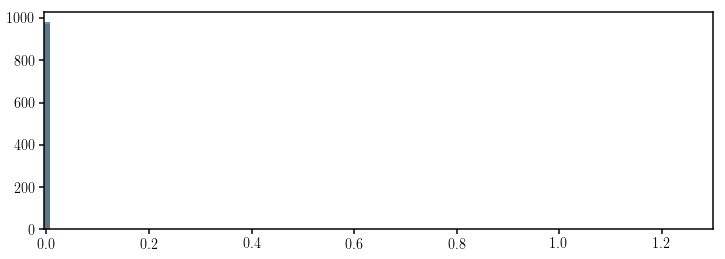

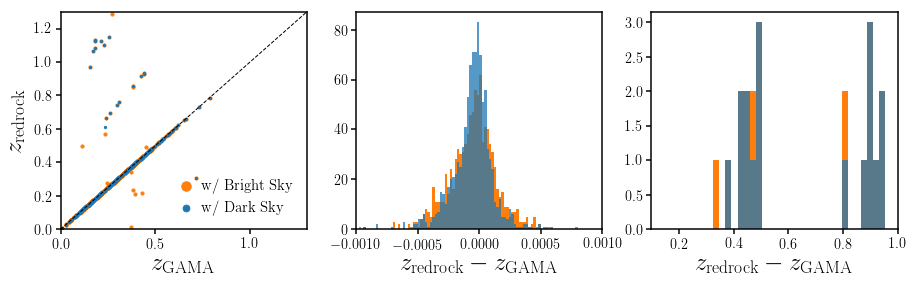

In [12]:
fig = plt.figure(figsize=(12,4))
sub = fig.add_subplot(111)
_ = sub.hist(zbright_data['Z'] - redshift[i_dark], color='C1', 
             range=(-0.005, 1.3), bins=100, histtype='stepfilled', label='w/ Bright Sky')
_ = sub.hist(zdark_data['Z'] - redshift[i_dark], color='C0', 
             range=(-0.005, 1.3), bins=100, histtype='stepfilled', alpha=0.75, label='w/ Dark Sky')
sub.set_xlim([-0.005, 1.3])


fig = plt.figure(figsize=(15,4))
sub = fig.add_subplot(131)
sub.scatter(redshift[i_dark], zbright_data['Z'], c='C1', s=10, label='w/ Bright Sky')
sub.scatter(redshift[i_dark], zdark_data['Z'], c='C0', s=5, label='w/ Dark Sky')
sub.plot([0., 10.], [0., 10.], c='k', lw=1, ls='--')
sub.set_xlabel(r"$z_\mathrm{GAMA}$", fontsize=25)
sub.set_xlim([0., 1.3])
sub.set_ylabel(r"$z_\mathrm{redrock}$", fontsize=25)
sub.set_ylim([0., 1.3])
sub.legend(loc='lower right', markerscale=3, handletextpad=0., prop={'size':15})
sub = fig.add_subplot(132)
_ = sub.hist(zbright_data['Z'] - redshift[i_dark], color='C1', 
             range=(-0.001, 0.001), bins=100, histtype='stepfilled', label='w/ Bright Sky')
_ = sub.hist(zdark_data['Z'] - redshift[i_dark], color='C0', 
             range=(-0.001, 0.001), bins=100, histtype='stepfilled', alpha=0.75, label='w/ Dark Sky')
sub.set_xlabel(r"$z_\mathrm{redrock} - z_\mathrm{GAMA}$", fontsize=25)
sub.set_xlim([-0.001, 0.001])
sub = fig.add_subplot(133)
_ = sub.hist(zbright_data['Z'] - redshift[i_dark], color='C1', 
             range=(0.1,1.), bins=40, histtype='stepfilled', label='w/ Bright Sky')
_ = sub.hist(zdark_data['Z'] - redshift[i_dark], color='C0', 
             range=(0.1,1.), bins=40, histtype='stepfilled', alpha=0.75, label='w/ Dark Sky')
sub.set_xlabel(r"$z_\mathrm{redrock} - z_\mathrm{GAMA}$", fontsize=25)
sub.set_xlim([0.1, 1.0])

In [13]:
print('Dark Sky: %i galaxies have Delta z > 0.003' % np.sum(zdark_data['Z'] - redshift[i_dark] > 0.003))
print('Bright Sky: %i galaxies have Delta z > 0.003' % np.sum(zbright_data['Z'] - redshift[i_dark] > 0.003))

Dark Sky: 18 galaxies have Delta z > 0.003
Bright Sky: 24 galaxies have Delta z > 0.003


(0.0, 0.001)

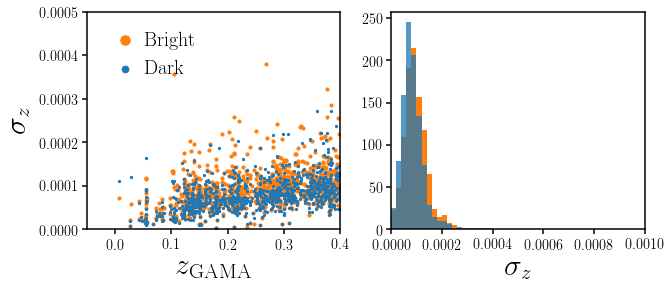

In [14]:
fig = plt.figure(figsize=(10,4))
sub = fig.add_subplot(121)
sub.scatter(redshift[i_dark], zbright_data['ZERR'], c='C1', s=10, label='Bright')
sub.scatter(redshift[i_dark], zdark_data['ZERR'], c='C0', s=5, label='Dark')
sub.set_xlabel(r"$z_\mathrm{GAMA}$", fontsize=30)
sub.set_xlim([-0.05, 0.4])
sub.set_ylabel(r"$\sigma_z$", fontsize=30)
sub.set_ylim([0, 5e-4])
sub.legend(loc='upper left', markerscale=3, handletextpad=0.0, prop={'size': 20})
sub = fig.add_subplot(122)
_ = sub.hist(zbright_data['ZERR'], color='C1', 
             range=(0., 0.001), bins=50, histtype='stepfilled', label='w/ Bright Sky')
_ = sub.hist(zdark_data['ZERR'], color='C0', 
             range=(0., 0.001), bins=50, histtype='stepfilled', alpha=0.75, label='w/ Dark Sky')
sub.set_xlabel(r"$\sigma_z$", fontsize=30)
sub.set_xlim([0., 0.001])

The redshift measurement from `redrock` have larger uncertainties for the bright sky. 

Now lets see the redshift success rate (quantified as $\Delta z/(1+z) < 0.01$) as a function of various parameters. 

In [15]:
def gethist(var, ztrue, zbest, range=None, threshold=0.003):
    """ 
    """
    dz = zbest - ztrue
    dz_1pz = np.abs(dz)/(1.+ztrue)
    s1 = (dz_1pz < threshold)
    
    h0, bins = np.histogram(var, bins=20, range=range)
    hv, _ = np.histogram(var, bins=bins, weights=var)
    h1, _ = np.histogram(var[s1], bins=bins)
    
    good = h0 > 2
    hv = hv[good]
    h0 = h0[good]
    h1 = h1[good]

    vv = hv / h0 # weighted mean of var
    
    def _eff(k, n):
        eff = k.astype("float") / (n.astype('float') + (n==0))
        efferr = np.sqrt(eff * (1 - eff)) / np.sqrt(n.astype('float') + (n == 0))
        return eff, efferr
    
    e1, ee1 = _eff(h1, h0)

    return vv, e1, ee1

Lets see how `redrock` redshift success rate, defined as $\Delta z /(1+z) < 0.003$, changes as a function of various properties

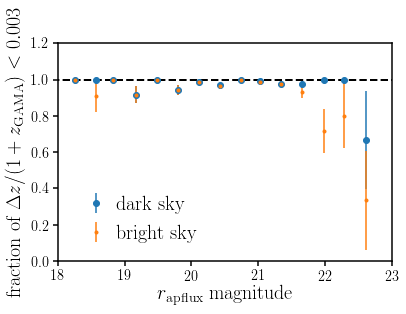

In [16]:
mm_dark, e1_dark, ee1_dark = gethist(r_mag_legacy_apflux[i_dark], redshift[i_dark], zdark_data['Z'])
mm_bright, e1_bright, ee1_bright = gethist(r_mag_legacy_apflux[i_dark], redshift[i_dark], zbright_data['Z'])

fig = plt.figure()
sub = fig.add_subplot(111)
sub.plot([17., 23.], [1., 1.], c='k', ls='--', lw=2)
sub.errorbar(mm_dark, e1_dark, ee1_dark, c='C0', fmt='o', label="dark sky")
sub.errorbar(mm_bright, e1_bright, ee1_bright, fmt='.C1', label="bright sky")
sub.set_xlabel(r'$r_\mathrm{apflux}$ magnitude', fontsize=20)
sub.set_xlim([18., 23.])
sub.set_ylabel(r'fraction of $\Delta z /(1+z_\mathrm{GAMA}) < 0.003$', fontsize=20)
sub.set_ylim([0., 1.2])
sub.legend(loc='lower left', handletextpad=0., prop={'size': 20})

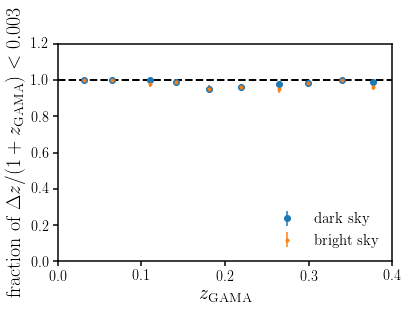

In [17]:
mm_dark, e1_dark, ee1_dark = gethist(redshift[i_dark], redshift[i_dark], zdark_data['Z'])
mm_bright, e1_bright, ee1_bright = gethist(redshift[i_dark], redshift[i_dark], zbright_data['Z'])

fig = plt.figure()
sub = fig.add_subplot(111)
sub.plot([0., 0.5], [1., 1.], c='k', ls='--', lw=2)
sub.errorbar(mm_dark, e1_dark, ee1_dark, c='C0', fmt='o', label="dark sky")
sub.errorbar(mm_bright, e1_bright, ee1_bright, fmt='.C1', label="bright sky")
sub.set_xlabel(r'$z_\mathrm{GAMA}$', fontsize=20)
sub.set_xlim([0.0, 0.4])
sub.set_ylabel(r'fraction of $\Delta z /(1+z_\mathrm{GAMA}) < 0.003$', fontsize=20)
sub.set_ylim([0., 1.2])
sub.legend(loc='lower right', prop={'size': 15})

(0.0, 1.2)

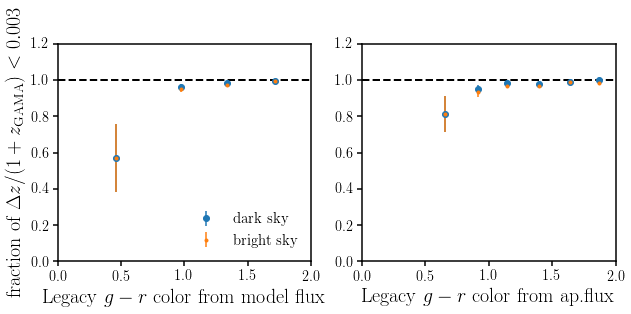

In [18]:
mm_dark, e1_dark, ee1_dark = gethist((g_mag_legacy - r_mag_legacy)[i_dark], redshift[i_dark], zdark_data['Z'])
mm_bright, e1_bright, ee1_bright = gethist((g_mag_legacy - r_mag_legacy)[i_dark], redshift[i_dark], zbright_data['Z'])

fig = plt.figure(figsize=(10,4))
sub = fig.add_subplot(121)
sub.plot([0., 2.], [1., 1.], c='k', ls='--', lw=2)
sub.errorbar(mm_dark, e1_dark, ee1_dark, c='C0', fmt='o', label="dark sky")
sub.errorbar(mm_bright, e1_bright, ee1_bright, fmt='.C1', label="bright sky")
sub.set_xlabel(r'Legacy $g-r$ color from model flux', fontsize=20)
sub.set_xlim([0., 2.])
sub.set_ylabel(r'fraction of $\Delta z /(1+z_\mathrm{GAMA}) < 0.003$', fontsize=20)
sub.set_ylim([0., 1.2])
sub.legend(loc='lower right', prop={'size': 15})

mm_dark, e1_dark, ee1_dark = gethist((g_mag_legacy_apflux - r_mag_legacy_apflux)[i_dark], redshift[i_dark], zdark_data['Z'])
mm_bright, e1_bright, ee1_bright = gethist((g_mag_legacy_apflux - r_mag_legacy_apflux)[i_dark], 
                                           redshift[i_dark], zbright_data['Z'])
sub = fig.add_subplot(122)
sub.plot([0., 2.], [1., 1.], c='k', ls='--', lw=2)
sub.errorbar(mm_dark, e1_dark, ee1_dark, c='C0', fmt='o', label="dark sky")
sub.errorbar(mm_bright, e1_bright, ee1_bright, fmt='.C1', label="bright sky")
sub.set_xlabel(r'Legacy $g-r$ color from ap.flux', fontsize=20)
sub.set_xlim([0., 2.])
sub.set_ylim([0., 1.2])


Now lets examine a handful of spectra to see where things go wrong and etc

In [59]:
from scipy.signal import medfilt
from redrock.external import desi
from redrock import templates as rr_templates

In [33]:
templates_path = RedRock.templates.find_templates(None)
templates = {} 
for el in templates_path: 
    t = RedRock.templates.Template(filename=el)
    templates[t.full_type] = t

DEBUG: Using default redshift range 0.0050-1.6988 for rrtemplate-galaxy.fits
DEBUG: Using default redshift range 0.0500-3.9968 for rrtemplate-qso.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-A.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-B.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-Carbon.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-F.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-G.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-K.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-Ldwarf.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-M.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-WD.fits


In [34]:
f_rr_dark = ''.join([UT.dat_dir(), 'redrock/', 
                     'GamaLegacy.', field, '.expSpectra.darksky.seed1.exptime300.faintEmLine.redrock.h5'])
f_rr_bright = ''.join([UT.dat_dir(), 'redrock/', 
                       'GamaLegacy.', field, '.expSpectra.brightsky.seed1.exptime300.faintEmLine.redrock.h5'])
zscan_dark, zfit_dark = RedRock.results.read_zscan(f_rr_dark)
zscan_bright, zfit_bright = RedRock.results.read_zscan(f_rr_bright)

In [66]:
f_spec_dark = ''.join([UT.dat_dir(), 'spectra/', 
                       'GamaLegacy.', field, '.expSpectra.darksky.seed1.exptime300.faintEmLine.fits'])

f_spec_bright = ''.join([UT.dat_dir(), 'spectra/', 
                         'GamaLegacy.', field, '.expSpectra.brightsky.seed1.exptime300.faintEmLine.fits']) 

In [67]:
target_bright = desi.DistTargetsDESI(f_spec_bright)._my_data
target_dark = desi.DistTargetsDESI(f_spec_dark)._my_data

In [102]:
def plotspec(target, zscan, zfit, xrange0=None, yrange0=None, xrange1=None, yrange1=None): 
    zfit_i = zfit[zfit['targetid'] == target.id]
    zz = zfit_i[zfit_i['znum'] == 0][0]
    coeff = zz['coeff']
    
    fulltype = zz['spectype']
    tp = templates[fulltype]
    
    fig = plt.figure(figsize=(12,8)) 
    _ax1 = fig.add_subplot(211)
    for spectype, fmt in [('STAR', 'k-'), ('GALAXY', 'b-'), ('QSO', 'g-')]:
        if spectype in zscan[target.id]:
            zx = zscan[target.id][spectype]
            _ax1.plot(zx['redshifts'], zx['zchi2'], fmt, alpha=0.2,
                      label='_none_')
            _ax1.plot(zx['redshifts'], zx['zchi2']+zx['penalty'], fmt,
                      label=spectype)
    #_ax1.plot(zfit['z'], zfit['chi2'], 'r.', label='_none_')
    if xrange0 is not None: _ax1.set_xlim(xrange0)
    if yrange0 is not None: _ax1.set_ylim(yrange0)
    for row in zfit_i: 
        if xrange0 is not None or yrange0 is not None:
            if xrange0 is not None: xif = (row['z'] > xrange0[0]) & (row['z'] < xrange0[1])
            else: xif = True
            if yrange0 is not None: yif = (row['chi2'] > yrange0[0]) & (row['chi2'] < yrange0[1])
            else: yif = True
            if (xif & yif): _ax1.text(row['z'], row['chi2'], str(row['znum']), verticalalignment='top')
        else:
            _ax1.text(row['z'], row['chi2'], str(row['znum']), verticalalignment='top', fontsize=20)
    _ax1.axvline(zz['z'], color='k', alpha=0.1)
    _ax1.axhline(zz['chi2'], color='k', alpha=0.1)
    _ax1.legend()
    _ax1.set_title('target {}  zbest={:.3f} {}'.format(target.id, zz['z'], zz['spectype']))
    _ax1.set_ylabel(r'$\chi^2$', fontsize=25)
    _ax1.set_xlabel('redshift', fontsize=25)
    
    _ax2 = fig.add_subplot(212)        
    specs_to_read = target.spectra
    ymin = ymax = 0.0
    for spec in specs_to_read:
        mx = tp.eval(coeff[0:tp.nbasis], spec.wave, zz['z']) * (1+zz['z'])
        model = spec.R.dot(mx)
        flux = spec.flux.copy()
        isbad = (spec.ivar == 0)
        ## model[isbad] = mx[isbad]
        flux[isbad] = np.NaN
        _ax2.plot(spec.wave, medfilt(flux, 1), alpha=0.5)
        _ax2.plot(spec.wave, medfilt(mx, 1), 'k:', alpha=0.8)
        model[isbad] = np.NaN
        _ax2.plot(spec.wave, medfilt(model, 1), 'k-', alpha=0.8)

        ymin = min(ymin, np.percentile(flux[~isbad], 1))
        ymax = max(ymax, np.percentile(flux[~isbad], 99), np.max(model)*1.05)

    #- Label object type and redshift
    label = 'znum {} {} z={:.3f}'.format(0, tp.full_type, zz['z'])
    #print('target {} id {} {}'.format(self.itarget, target.id, label))
    ytext = ymin+0.9*(ymax-ymin)
    if xrange1 is not None: _ax2.text(xrange1[0], ytext, label)
    else: _ax2.text(3800, ytext, label)
    _ax2.set_ylim(ymin, ymax)
    _ax2.set_xlim(3500,10100)   
    _ax2.set_ylabel('flux', fontsize=25)
    _ax2.set_xlabel('wavelength [A]', fontsize=25)    
    fig.subplots_adjust(hspace=0.3)
    plt.show()

In [109]:
def chi2_lambda(target, zscan, zfit, xrange=None, yrange=None):
    ''' plot chi-squared as a function of wavelength 
    '''
    zfit_i = zfit[zfit['targetid'] == target.id]
    zz = zfit_i[zfit_i['znum'] == 0][0]
    coeff = zz['coeff']
    
    fulltype = zz['spectype']
    tp = templates[fulltype]
    
    fig = plt.figure(figsize=(12,4)) 
    sub = fig.add_subplot(111)
    
    specs_to_read = target.spectra
    ymin = ymax = 0.0
    for spec in specs_to_read:
        mx = tp.eval(coeff[0:tp.nbasis], spec.wave, zz['z']) * (1+zz['z'])
        model = spec.R.dot(mx)
        flux = spec.flux.copy()
        ivar = spec.ivar.copy() 
        isbad = (spec.ivar == 0)
        chi2 = (flux - model)**2 * ivar
        ## model[isbad] = mx[isbad]
        chi2[isbad] = np.NaN
        sub.plot(spec.wave, chi2) #medfilt(flux, 1), alpha=0.5)
        #_ax2.plot(spec.wave, medfilt(mx, 1), 'k:', alpha=0.8)
        #model[isbad] = np.NaN
        #_ax2.plot(spec.wave, medfilt(model, 1), 'k-', alpha=0.8)

        ymin = min(ymin, np.percentile(chi2[~isbad], 1))
        ymax = max(ymax, np.percentile(chi2[~isbad], 99), np.max(chi2)*1.05)

    #- Label object type and redshift
    label = 'znum {} {} z={:.3f}'.format(0, tp.full_type, zz['z'])
    if yrange is not None: ymin, ymax = yrange
    ytext = ymin+0.9*(ymax-ymin)
    if xrange is not None: sub.text(xrange[0], ytext, label)
    else: sub.text(3800, ytext, label)
    if yrange is not None: sub.set_ylim(yrange)
    else: sub.set_ylim(ymin, ymax)
    sub.set_xlim(3500,10100)   
    sub.set_ylabel('$\chi^2(\lambda)$', fontsize=25)
    sub.set_xlabel('wavelength [A]', fontsize=25)    
    fig.subplots_adjust(hspace=0.3)
    plt.show()

In [108]:
def chi2z(target, zscan, zfit, xranges=None, yranges=None):
    zfit_i = zfit[zfit['targetid'] == target.id]
    zz = zfit_i[zfit_i['znum'] == 0][0]
    coeff = zz['coeff']
    
    fulltype = zz['spectype']
    tp = templates[fulltype]
    
    fig = plt.figure(figsize=(4*len(xranges),4)) 
    for i in range(len(xranges)): 
        _ax1 = fig.add_subplot(1,len(xranges),i+1)
        for spectype, fmt in [('STAR', 'k-'), ('GALAXY', 'b-'), ('QSO', 'g-')]:
            if spectype in zscan[target.id]:
                zx = zscan[target.id][spectype]
                _ax1.plot(zx['redshifts'], zx['zchi2'], fmt, alpha=0.2,
                          label='_none_')
                _ax1.plot(zx['redshifts'], zx['zchi2']+zx['penalty'], fmt,
                          label=spectype)
        _ax1.plot(zfit['z'], zfit['chi2'], 'r.', label='_none_')
        if xranges is not None: _ax1.set_xlim(xranges[i])
        if yranges is not None: _ax1.set_ylim(yranges[i])
        for row in zfit_i: 
            if xranges is not None or yranges is not None:
                if xranges is not None: xif = (row['z'] > xranges[i][0]) & (row['z'] < xranges[i][1])
                else: xif = True
                if yranges is not None: yif = (row['chi2'] > yranges[i][0]) & (row['chi2'] < yranges[i][1])
                else: yif = True
                if (xif & yif): _ax1.text(row['z'], row['chi2'], str(row['znum']), verticalalignment='top')
            else:
                _ax1.text(row['z'], row['chi2'], str(row['znum']), verticalalignment='top', fontsize=20)
        _ax1.axvline(zz['z'], color='k', alpha=0.1)
        _ax1.axhline(zz['chi2'], color='k', alpha=0.1)
        #_ax1.legend()
        _ax1.set_title('target {}  zbest={:.3f} {}'.format(target.id, zz['z'], zz['spectype']))
        _ax1.set_xlabel('redshift', fontsize=25)
        if i == 0: _ax1.set_ylabel(r'$\chi^2$', fontsize=25)
    fig.subplots_adjust(wspace=0.3)
    plt.show()

(3500, 10100)

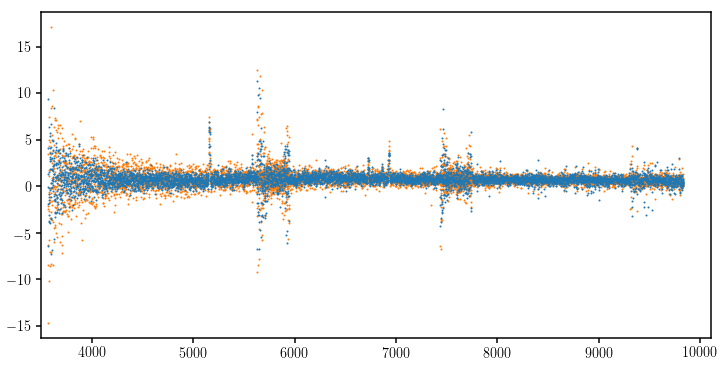

In [70]:
fig = plt.figure(figsize=(12,6)) 
sub = fig.add_subplot(111)
for s_dark, s_bright in zip(target_dark[0].spectra, target_bright[0].spectra):
    sub.scatter(s_bright.wave, s_bright.flux, s=1, c='C1')
    sub.scatter(s_dark.wave, s_dark.flux, s=1, c='C0')
sub.set_xlim(3500,10100)   

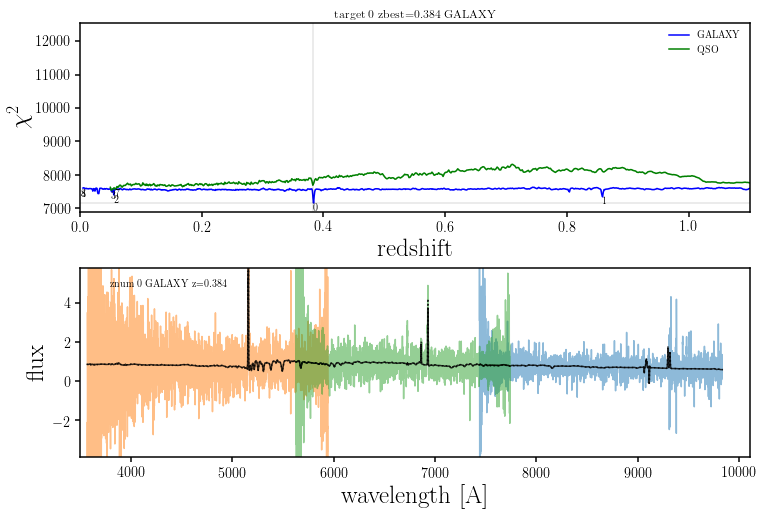

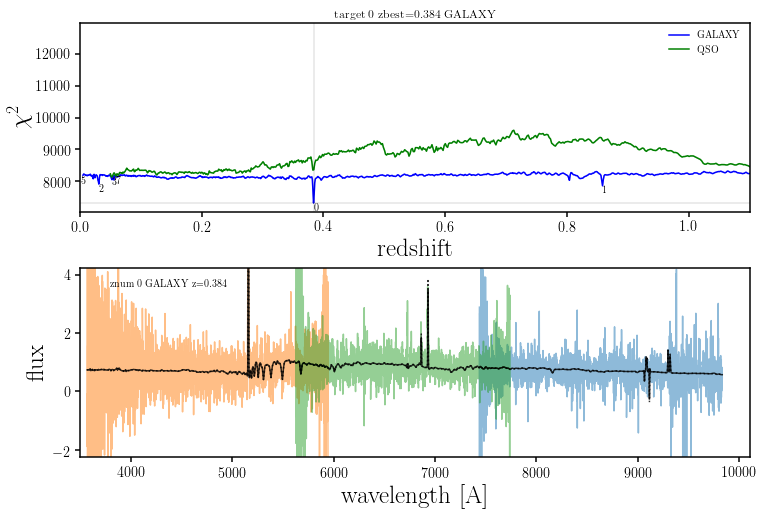

In [79]:
plotspec(target_bright[0], zscan_bright, zfit_bright, xrange0=[0.,1.1])
plotspec(target_dark[0], zscan_dark, zfit_dark, xrange0=[0.,1.1])

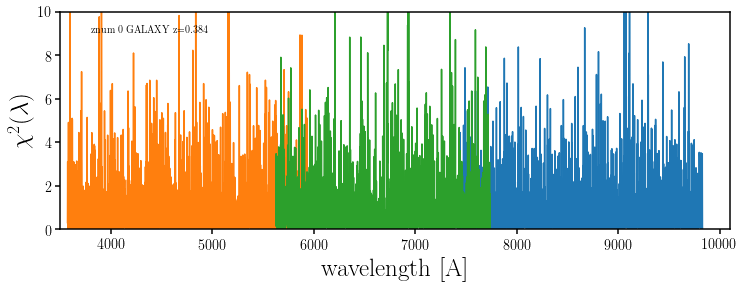

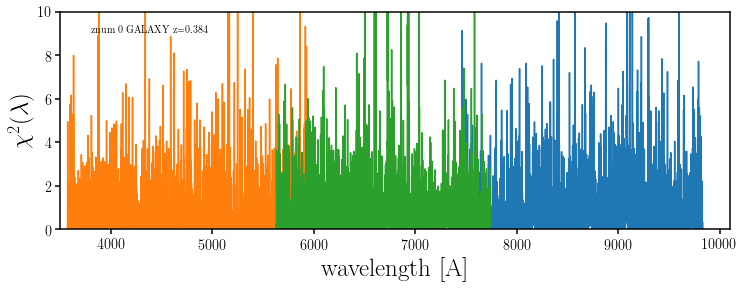

In [96]:
chi2_lambda(target_bright[0], zscan_bright, zfit_bright, yrange=[0., 10.])
chi2_lambda(target_dark[0], zscan_dark, zfit_dark, yrange=[0.,10.])

In [98]:
zfail_onlybright = ((zdark_data['Z'] - redshift[i_dark] < 0.003) & (zbright_data['Z'] - redshift[i_dark] > 0.003))
print('redrock fails for %i galaxies with bright sky' % np.sum(zfail_onlybright))
print(np.arange(len(zdark_data['Z']))[zfail_onlybright])

redrock fails for 7 galaxies with bright sky
[291 384 481 641 644 670 801]


(3500, 10100)

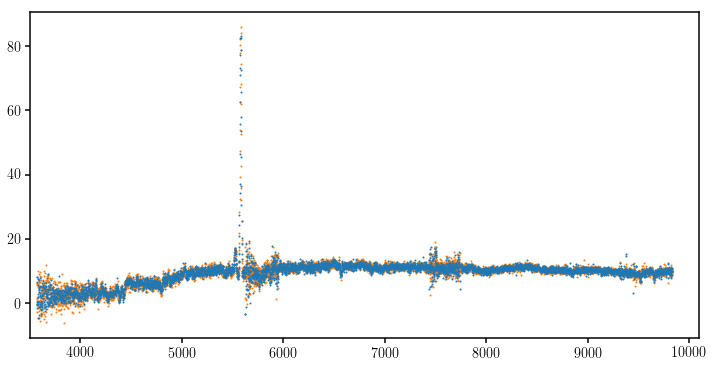

In [99]:
fig = plt.figure(figsize=(12,6)) 
sub = fig.add_subplot(111)
for s_dark, s_bright in zip(target_dark[291].spectra, target_bright[291].spectra):
    sub.scatter(s_bright.wave, s_bright.flux, s=1, c='C1')
    sub.scatter(s_dark.wave, s_dark.flux, s=1, c='C0')
sub.set_xlim(3500,10100)   

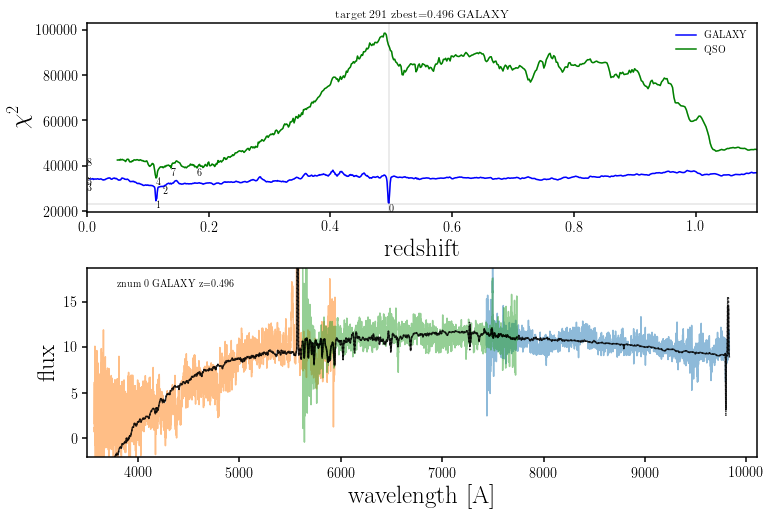

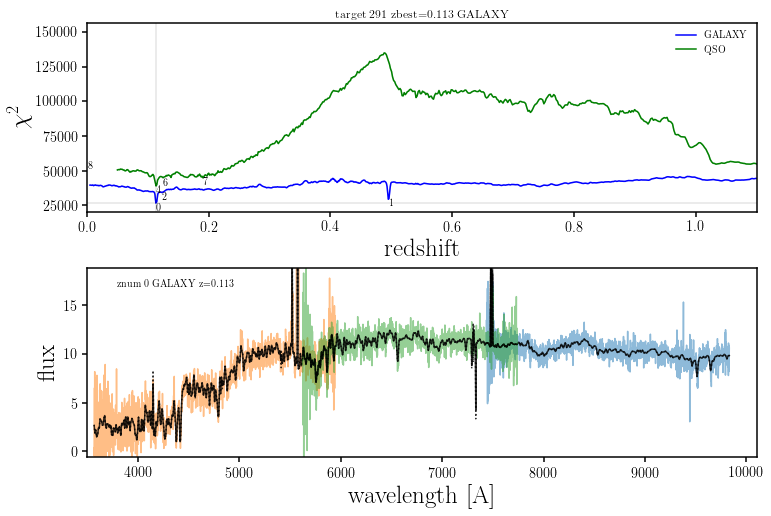

In [103]:
plotspec(target_bright[291], zscan_bright, zfit_bright, xrange0=[0.,1.1])
plotspec(target_dark[291], zscan_dark, zfit_dark, xrange0=[0.,1.1])

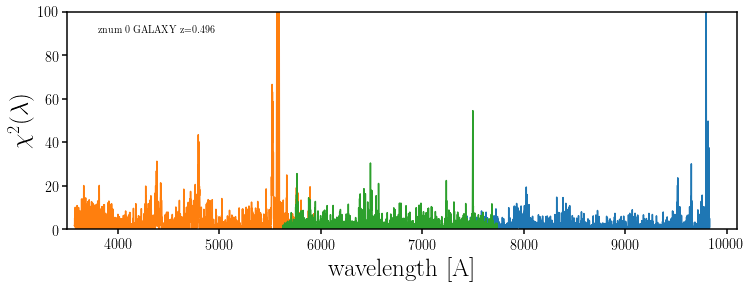

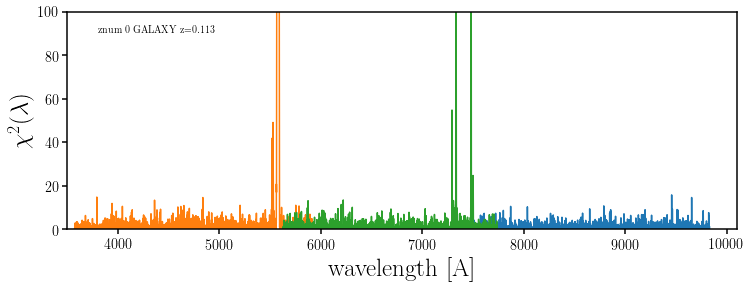

In [111]:
chi2_lambda(target_bright[291], zscan_bright, zfit_bright, yrange=[0., 100.])
chi2_lambda(target_dark[291], zscan_dark, zfit_dark, yrange=[0., 100.])